In [184]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pickle
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy import signal
import nrrd
from PIL import Image

In [185]:
fname_epi = "/work/jprieto/data/remote/EGower/hinashah/Analysis_Set_11012021/trachoma_normals_healthy_sev123_epi_patches_test.csv"

df_epi = pd.read_csv(fname_epi)
df_epi.drop(df_epi[df_epi['patch_class'].isin(['Probable Epilation', 'Probable TT'])].index, inplace = True)
df_epi = df_epi.reset_index()
df_epi = df_epi.replace({'Healthy': 0, 'TT': 1, 'Epilation': 2})

with open("/work/jprieto/data/remote/EGower/jprieto/test_output/patch_training_resnet_03122021.pickle", 'rb') as f:
    results_epi = pickle.load(f)

pred_np, conf_np, feat_np = results_epi
    
pred_np = np.array(pred_np)
conf_np = np.array(conf_np)
feat_np = np.array(feat_np)

print(pred_np.shape)
print(conf_np.shape)
print(feat_np.shape)

# results_epi.drop(results_epi[results_epi['patch_class'].isin(['Probable Epilation', 'Probable TT'])].index, inplace = True)
# results_epi = results_epi.reset_index()
# results_epi = results_epi.replace({'Healthy': 0, 'TT': 1, 'Epilation': 2})

(9636, 3)
(9636, 1)
(9636, 512)


In [186]:
df_epi["pred"] = np.argmax(pred_np, axis=1)
df_epi["conf"] = conf_np

In [187]:
csv_true_column = "patch_class"
csv_prediction_column = "pred"
y_true_arr = [] 
y_pred_arr = []
for idx, row in df_epi.iterrows():
  y_true_arr.append(row[csv_true_column])
  y_pred_arr.append(row[csv_prediction_column])


In [188]:
cnf_matrix = confusion_matrix(y_true_arr, y_pred_arr)
print(cnf_matrix)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
print(cnf_matrix_norm)
print(classification_report(y_true_arr, y_pred_arr))

[[5031  132  198]
 [  91 3102  145]
 [  77   50  810]]
[[0.93844432 0.02462227 0.03693341]
 [0.02726183 0.92929898 0.04343919]
 [0.08217716 0.05336179 0.86446105]]
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      5361
           1       0.94      0.93      0.94      3338
           2       0.70      0.86      0.78       937

    accuracy                           0.93      9636
   macro avg       0.87      0.91      0.89      9636
weighted avg       0.93      0.93      0.93      9636



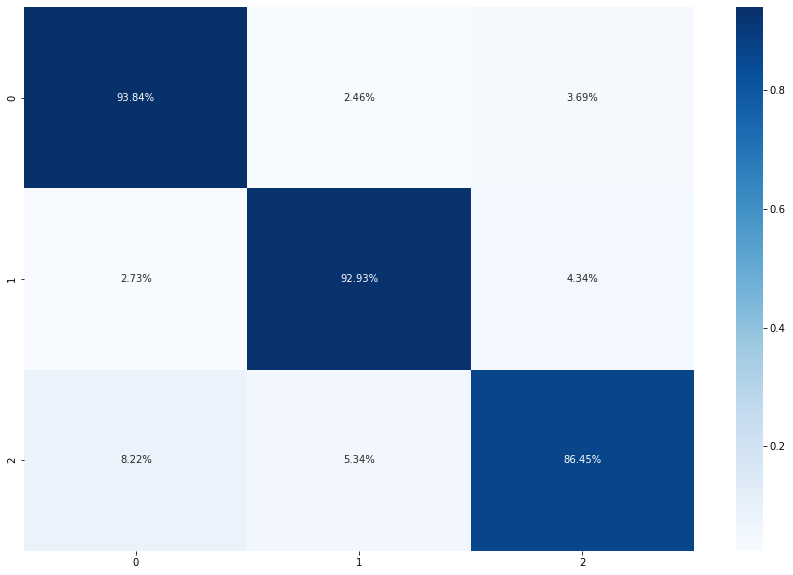

In [90]:
plt.figure(figsize=[15,10])
sns.heatmap(cnf_matrix_norm, annot=True, fmt='.2%', cmap='Blues')
plt.show()

In [122]:
new_pred = []

for idx, row in df_epi.iterrows():
    
    if(row["pred"] == 0 and row["conf"] < 0.95):
        new_pred.append(1)
    else:
        new_pred.append(row["pred"])


df_epi["new_pred"] = new_pred

[[4343  820  198]
 [  23 3170  145]
 [  44   83  810]]
[[0.81011005 0.15295654 0.03693341]
 [0.00689035 0.94967046 0.04343919]
 [0.04695838 0.08858058 0.86446105]]
              precision    recall  f1-score   support

           0       0.98      0.81      0.89      5361
           1       0.78      0.95      0.86      3338
           2       0.70      0.86      0.78       937

    accuracy                           0.86      9636
   macro avg       0.82      0.87      0.84      9636
weighted avg       0.89      0.86      0.87      9636



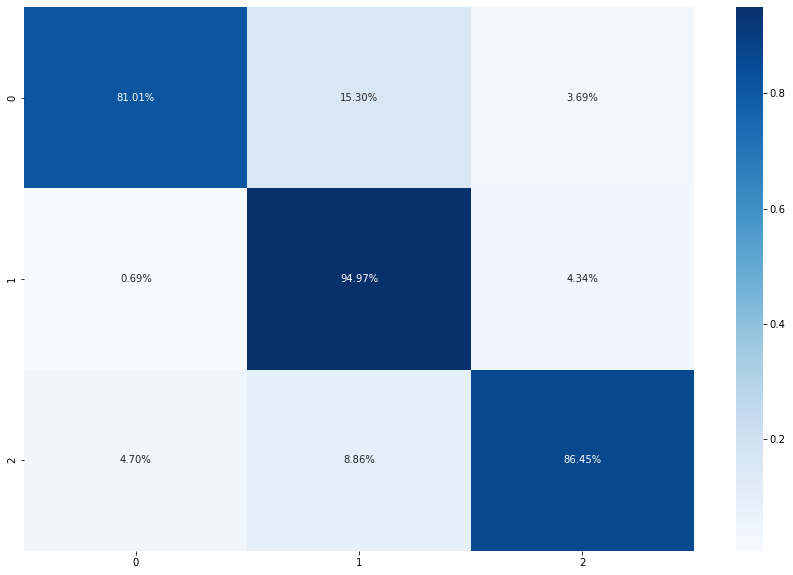

In [123]:
csv_true_column = "patch_class"
csv_prediction_column = "new_pred"
y_true_arr = [] 
y_pred_arr = []
for idx, row in df_epi.iterrows():
  y_true_arr.append(row[csv_true_column])
  y_pred_arr.append(row[csv_prediction_column])
    
cnf_matrix = confusion_matrix(y_true_arr, y_pred_arr)
print(cnf_matrix)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
print(cnf_matrix_norm)
print(classification_report(y_true_arr, y_pred_arr))

plt.figure(figsize=[15,10])
sns.heatmap(cnf_matrix_norm, annot=True, fmt='.2%', cmap='Blues')
plt.show()

In [91]:
pca_epi = PCA(n_components=2)
pca_epi_fit = pca.fit_transform(feat_np)
df_epi["pca_0"] = pca_epi_fit[:,0]
df_epi["pca_1"] = pca_epi_fit[:,1]

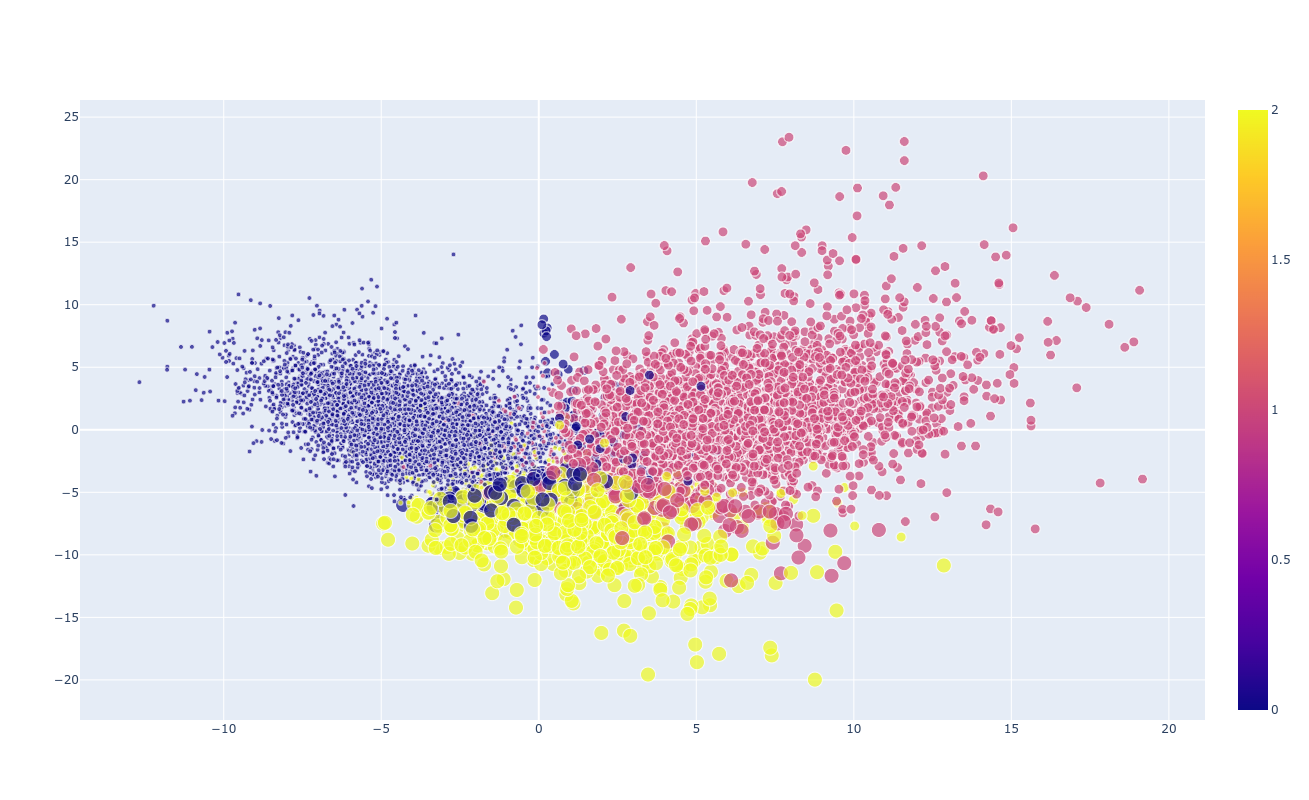

In [97]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_epi["pca_0"], y=df_epi["pca_1"], mode='markers', text=df_epi["pred"], marker=dict(color=df_epi["patch_class"], size=(df_epi["pred"]+1)*5, showscale=True)))
fig.update_layout(
    autosize=False,
    width=1200,
    height=800
)
fig

In [113]:
df_miss_classified = df_epi.query("pred != patch_class")
df_classified = df_epi.query("pred == patch_class")
df_tt = df_epi.query("patch_class > 0 and pred == 0")

fig = go.FigureWidget(make_subplots(rows=1, cols=3, column_widths=[0.33, 0.33, 0.33], specs=[[{}, {}, {}]]))

fig.add_trace(go.Scatter(x=df_miss_classified["pca_0"], y=df_miss_classified["pca_1"], mode='markers', text=df_miss_classified["conf"], marker=dict(color=df_miss_classified["conf"], showscale=False, cmin=0, cmax=1)), row=1, col=1)
fig.add_trace(go.Scatter(x=df_classified["pca_0"], y=df_classified["pca_1"], mode='markers', text=df_classified["conf"], marker=dict(color=df_classified["conf"], showscale=False, cmin=0, cmax=1)), row=1, col=2)
fig.add_trace(go.Scatter(x=df_tt["pca_0"], y=df_tt["pca_1"], mode='markers', text=df_tt["conf"], marker=dict(color=df_tt["conf"], showscale=True, cmin=0, cmax=1)), row=1, col=3)


fig.update_layout(
    autosize=False,
    width=1500,
    height=600
)
fig

FigureWidget({
    'data': [{'marker': {'cmax': 1,
                         'cmin': 0,
                       …

In [112]:
print(df_miss_classified["conf"].describe())
print(df_classified["conf"].describe())
print(df_tt["conf"].describe())

count    693.000000
mean       0.876371
std        0.115412
min        0.212748
25%        0.829267
50%        0.912149
75%        0.962513
max        0.998185
Name: conf, dtype: float64
count    8943.000000
mean        0.949629
std         0.079260
min         0.055155
25%         0.940207
50%         0.980064
75%         0.994542
max         1.000000
Name: conf, dtype: float64
count    168.000000
mean       0.912314
std        0.075987
min        0.566705
25%        0.879497
50%        0.936255
75%        0.965135
max        0.996905
Name: conf, dtype: float64


In [114]:
df_healthy = df_epi.query("patch_class == 0")
df_healthy["conf"].describe()

count    5361.000000
mean        0.972221
std         0.041376
min         0.508970
25%         0.965965
50%         0.987230
75%         0.995824
max         0.999989
Name: conf, dtype: float64

In [ ]:
# x_v_features_np = np.reshape(np.array(x_v_features), (-1, 256)).astype(float)
# print(np.shape(x_v_features_np), x_v_features_np.dtype)
# values_embedded = TSNE(n_components=2, init='pca').fit_transform(x_v_features_np)
# df_epi["tsne_0"] = values_embedded[:,0]
# df_epi["tsne_1"] = values_embedded[:,1]
# result_df["scores_max"] = [np.max(s.reshape(-1), axis=0) for s in scores]
# result_df["prediction_abs"] = np.abs(result_df["truth"] - result_df["pred"]) = np.reshape(np.array(features), (-1, 128)).astype(float)
# print(np.shape(features_np), features_np.dtype)
# X_embedded = TSNE(n_components=2, init='pca').fit_transform(features_np)
# result_df["tsne_0"] = X_embedded[:,0]
# result_df["tsne_1"] = X_embedded[:,1]
# result_df["scores_max"] = [np.max(s.reshape(-1), axis=0) for s in scores]
# result_df["prediction_abs"] = np.abs(result_df["truth"] - result_df["pred"])

In [8]:
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=df_epi["tsne_0"], y=df_epi["tsne_1"], mode='markers', text=df_epi["pred"], marker=dict(color=df_epi["patch_class"], size=(df_epi["pred"]+1)*5, showscale=True)))
# fig.show()

In [174]:
csv_path_stacks = "/work/jprieto/data/remote/EGower/hinashah/Analysis_Set_11012021/trachoma_normals_healthy_sev123_epi_stacks_16_544_test.csv"
output_dir = "/work/jprieto/data/remote/EGower/jprieto/test_output/"
results_stacks_path = os.path.join(output_dir, 'stack_training_resnet_conf_03122021.pickle')#stack_training_resnet_conf_10122021.pickle

In [175]:
df_stacks = pd.read_csv(csv_path_stacks)
with open(results_stacks_path, 'rb') as f:
    results_stacks = pickle.load(f) #x, c, x_a, x_v, x_s, x_f
    
print(len(results_stacks), len(df_stacks))

6 926


In [176]:
df_stacks["pred"] = np.argmax(results_stacks[0], axis=1)
df_stacks["conf"] = results_stacks[1].reshape(-1)

In [177]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(results_stacks[2])
df_stacks["pca_0"] = X_pca[:,0]
df_stacks["pca_1"] = X_pca[:,1]
x_v_features_np = results_stacks[3]
x_s_np = results_stacks[4]
x_v_p_np = results_stacks[5]

[[160  16]
 [143 607]]
[[0.90909091 0.09090909]
 [0.19066667 0.80933333]]
              precision    recall  f1-score   support

           0       0.53      0.91      0.67       176
           1       0.97      0.81      0.88       750

    accuracy                           0.83       926
   macro avg       0.75      0.86      0.78       926
weighted avg       0.89      0.83      0.84       926



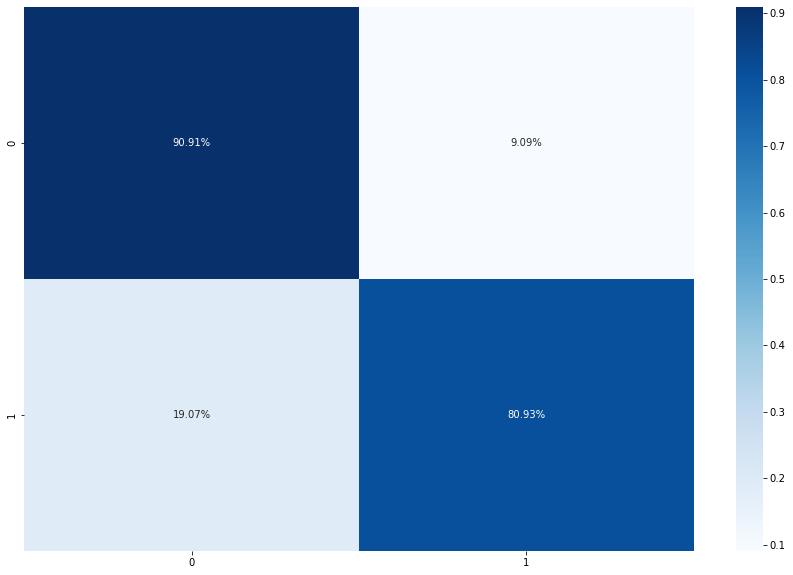

In [178]:
y_true_arr_stacks = [] 
y_pred_arr_stacks = []
for idx, row in df_stacks.iterrows():
  y_true_arr_stacks.append(row["class"])
  y_pred_arr_stacks.append(row["pred"])
    
cnf_matrix_stacks = confusion_matrix(y_true_arr_stacks, y_pred_arr_stacks)
print(cnf_matrix_stacks)
cnf_matrix_norm_stacks = cnf_matrix_stacks.astype('float') / cnf_matrix_stacks.sum(axis=1)[:, np.newaxis]
print(cnf_matrix_norm_stacks)
print(classification_report(y_true_arr_stacks, y_pred_arr_stacks))

plt.figure(figsize=[15,10])
sns.heatmap(cnf_matrix_norm_stacks, annot=True, fmt='.2%', cmap='Blues')
plt.show()

[[127  49]
 [116 634]]
[[0.72159091 0.27840909]
 [0.15466667 0.84533333]]
              precision    recall  f1-score   support

           0       0.52      0.72      0.61       176
           1       0.93      0.85      0.88       750

    accuracy                           0.82       926
   macro avg       0.73      0.78      0.75       926
weighted avg       0.85      0.82      0.83       926



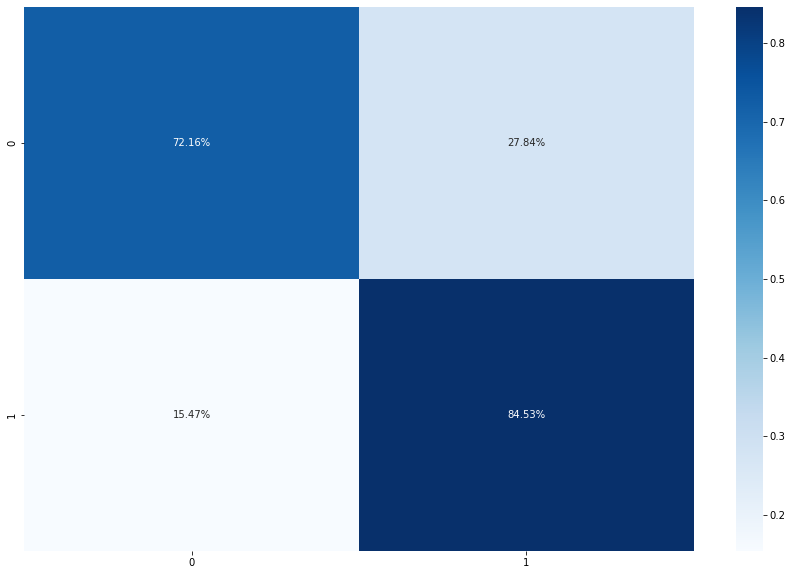

In [182]:
new_pred = []

for idx, row in df_stacks.iterrows():
    
    if(row["pred"] == 0 and row["conf"] < 0.5):
        new_pred.append(1)
    else:
        new_pred.append(row["pred"])


df_stacks["new_pred"] = new_pred

y_true_arr_stacks = [] 
y_pred_arr_stacks = []
for idx, row in df_stacks.iterrows():
  y_true_arr_stacks.append(row["class"])
  y_pred_arr_stacks.append(row["new_pred"])
    
cnf_matrix_stacks = confusion_matrix(y_true_arr_stacks, y_pred_arr_stacks)
print(cnf_matrix_stacks)
cnf_matrix_norm_stacks = cnf_matrix_stacks.astype('float') / cnf_matrix_stacks.sum(axis=1)[:, np.newaxis]
print(cnf_matrix_norm_stacks)
print(classification_report(y_true_arr_stacks, y_pred_arr_stacks))

plt.figure(figsize=[15,10])
sns.heatmap(cnf_matrix_norm_stacks, annot=True, fmt='.2%', cmap='Blues')
plt.show()

In [159]:
df_stacks

,img,class,severity_class,pred,conf,pca_0,pca_1,new_pred
0,jprieto/trachoma_normals_healthy_sev123_051820...,0,0,0,0.997978,-3.525583,0.329371,0
1,jprieto/trachoma_normals_healthy_sev123_051820...,1,3,1,0.999164,5.367651,-1.349177,1
2,jprieto/trachoma_normals_healthy_sev123_051820...,1,3,1,0.999164,5.367651,-1.349182,1
3,jprieto/trachoma_normals_healthy_sev123_051820...,0,0,0,0.997875,-5.409448,1.039730,0
4,jprieto/trachoma_normals_healthy_sev123_051820...,1,3,1,0.999766,2.633411,1.851477,1
...,...,...,...,...,...,...,...,...
921,jprieto/trachoma_normals_healthy_sev123_051820...,1,2,1,0.999928,6.938938,1.017802,1
922,jprieto/trachoma_normals_healthy_sev123_051820...,1,1,0,0.959928,-3.697827,-1.931221,0
923,jprieto/trachoma_normals_healthy_sev123_051820...,1,3,1,0.999595,5.524865,-0.729421,1
924,jprieto/trachoma_normals_healthy_sev123_051820...,1,1,0,0.991819,-3.550166,-0.876811,0


In [183]:
fig = go.FigureWidget(make_subplots(rows=2, cols=2, column_widths=[0.7, 0.3], specs=[[{'colspan': 2}, {}],[{},{}]]))

fig.add_trace(go.Scatter(x=df_stacks["pca_0"], y=df_stacks["pca_1"], mode='markers', showlegend=False, marker=dict(
    color=df_stacks["class"], size=(df_stacks["pred"] + 1)*5, colorscale='sunset', showscale=True, opacity=1, line=dict(color='red', width=1)
)), row=1, col=1)
fig.add_trace(go.Scatter(mode='markers', showlegend=False, marker=dict(showscale=True, size=10, cmin=np.min(x_v_p_np), cmax=np.max(x_v_p_np), colorscale='sunset', line=dict(color='red', width=1))), row=2, col=1)
fig.add_trace(go.Scatter(mode='markers', marker=dict(color='LightSkyBlue', size=10), showlegend=False), row=2, col=1)
fig.add_trace(go.Image(), row=2, col=2)

fig.data[0].marker.showscale = True
fig.data[0].marker.colorbar.y = 0.8
fig.data[0].marker.colorbar.len = 0.5

fig.data[1].marker.showscale = True
fig.data[1].marker.colorbar.y = .2
fig.data[1].marker.colorbar.len = 0.5

fig.update_layout(
    autosize=False,
    width=1200,
    height=800
)

current_idx = {"idx": 0, "idx_f": 0, "img_np": []}

def update_study(trace, points, selector):
    if points.trace_name == 'trace 0' and len(points.point_inds) > 0:
        print("update_study", points)
        idx = points.point_inds[0]  
        x_feat_idx = np.array(x_v_features_np[idx]).reshape(-1, 256)
        x_feat_idx_pca = pca.transform(x_feat_idx)
        print(x_feat_idx_pca.shape)
#         scores_idx = np.array(scores[idx]).reshape(-1)
#         weights_idx = np.array(weights[idx]).reshape(-1)
        print(x_v_p_np.shape)
        df_idx = pd.DataFrame({
            "pca_0": x_feat_idx_pca[:,0],
            "pca_1": x_feat_idx_pca[:,1],
            "pred": np.array(np.argmax(x_v_p_np[idx], axis=1)).reshape(-1), 
            "score": np.array(x_s_np[idx]).reshape(-1)
#             ,
#             "scores": scores_idx,
#             "weights": weights_idx
            })

        with fig.batch_update():
            fig.data[1]['x'] = df_idx["pca_0"]
            fig.data[1]['y'] = df_idx["pca_1"]
            fig.data[1].marker.color = df_idx['pred']
            fig.data[1].text = ['s: {:f}, p: {:f}'.format(s, p) for s, p in zip(df_idx['score'], df_idx['pred'])]
#             fig.data[1].marker.cmin = np.max()
#             fig.data[1].marker.cmax = 1
            
            fig.data[2]['x'] = [df_stacks.loc[idx]["pca_0"]]
            fig.data[2]['y'] = [df_stacks.loc[idx]["pca_1"]]

            current_idx["idx"] = idx
            
            current_idx["img_np"] = nrrd.read(os.path.join("/work/jprieto/data/remote/EGower/", df_stacks.loc[idx]["img"]), index_order='C')[0]
            
fig.data[0].on_click(update_study)

def update_img(trace, points, selector):
    if points.trace_name == 'trace 1' and len(points.point_inds) > 0:
        print('update_img', points)
        idx_f = points.point_inds[0] 
        current_idx["idx_f"] = idx_f
        with fig.batch_update():
#             fig.data[3]['z'] = current_idx["img_np"][idx_f]
            print(idx_f)
            fig.data[3]['z'] = current_idx["img_np"][idx_f]
    
fig.data[1].on_click(update_img)

fig

FigureWidget({
    'data': [{'marker': {'color': array([0, 1, 1, ..., 1, 1, 1]),
                         'col…